In [1]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

from IPython.display import display, Image, Markdown
from dotenv import load_dotenv

import os


load_dotenv()

True

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

### Query Rewrite

In [4]:
from states import (CreativeWritingAgentState, StoryIdeaGeneratorState, CharacterOutlineGeneratorState,
                    DraftWriterState, MacroEditorState, MicroEditorState)
from models import (QueryToDescription, StoryIdeaList, StoryIdeaFeedback, CharactersList, SceneOutlineList,
                    CharacterOutlineCritic, MacroEditorFeedbackList, MicroEditorFeedbackList, OrchestratorDecision)

from prompts import (QUERY_PARSER_PROMPT, STORY_IDEAS_GENERATOR_PROMPT, STORY_IDEA_FEEDBACK_PROMPT,
                     CHARACTER_GENERATOR_PROMPT, SCENE_OUTLINE_GENERATOR_PROMPT, CHARACTER_OUTLINE_CRITIC_PROMPT,
                     DRAFT_WRITER_PROMPT, MACRO_EDITOR_PROMPT, MICRO_EDITOR_PROMPT)


In [5]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0.5,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [6]:
def query_rewriter(state: CreativeWritingAgentState) -> CreativeWritingAgentState:
    query = state['query']
    
    system_prompt = QUERY_PARSER_PROMPT.format(query=query)
    llm_structured = llm.with_structured_output(QueryToDescription)
    
    response = llm_structured.invoke([SystemMessage(content=system_prompt), HumanMessage(content="Write a perfect description with reasoning")])
    
    return {"description": response.description, "messages": [AIMessage(content=response.reasoning)]}

### Ideas Generation and Iteration

In [29]:
def story_ideas_generator(state: StoryIdeaGeneratorState) -> StoryIdeaGeneratorState:
    description = state['description']
    max_story_ideas = state['max_story_ideas']
    story_ideas = state.get('story_ideas', [])
    human_feedback = state.get('human_feedback', '')
    
    previous_story_ideas = "\n".join([f"Story Title: {story.title}\nStory Synopsis: {story.synopsis}\nStory Genre: {story.genre}\nStory Tone: {story.tone}\nStory Hook: {story.hook}" for story in story_ideas])
    
    
    system_prompt = STORY_IDEAS_GENERATOR_PROMPT.format(description=description, 
                                                        max_story_ideas=max_story_ideas,
                                                        previous_story_ideas=previous_story_ideas,
                                                        human_feedback=human_feedback)
    
    structured_llm = llm.with_structured_output(StoryIdeaList)
    
    response = structured_llm.invoke(system_prompt)
    
    for index, story in enumerate(response.story_ideas):
        print(f"Story {index+1}:")
        print(f"Title: {story.title}")
        print(f"Synopsis: {story.synopsis}")
        print(f"Genre: {story.genre}")
        print(f"Tone: {story.tone}")
        print(f"Hook: {story.hook}")
        print("-"*100)
        print("\n")
    
    print(f"Let us know which one you like the most by mentioning the index of the story")
    print(f"Or Give us a feedback for the story or Let the agent pick one for you")
    
    
    return {"story_ideas": response.story_ideas, "messages": [AIMessage(content=response.reasoning)]}

def stories_human_feedback_handler(state: StoryIdeaGeneratorState) -> StoryIdeaGeneratorState:
    feedback = state.get('human_feedback', None)
    story_ideas_str = "\n".join([f"Story {index+1}:\nTitle: {story.title}\nSynopsis: {story.synopsis}\nGenre: {story.genre}\nTone: {story.tone}\nHook: {story.hook}" for index, story in enumerate(state['story_ideas'])])
    
    system_prompt = STORY_IDEA_FEEDBACK_PROMPT.format(story_ideas=story_ideas_str, 
                                                      human_feedback=feedback)
    
    llm_structured = llm.with_structured_output(StoryIdeaFeedback)
    response = llm_structured.invoke(system_prompt)
    
    reasoning = response.reasoning
    direction = response.direction
    
    if direction == "REGENERATE":
        return {"messages": [AIMessage(content=reasoning)], "final_story_idea": None}
    elif direction.startswith("SELECT"):
        if len(direction.split(",")) > 1:
            index = int(direction.split(",")[1]) - 1
            if index > len(state['story_ideas']) or index < 0:
                return {"messages": [AIMessage(content=f"Wrong Response from the model {direction}")], "final_story_idea": None}
            else:
                return {"final_story_idea": state['story_ideas'][index], "messages": [AIMessage(content=reasoning)]}
        else:
            return {"messages": [AIMessage(content=f"Wrong Response from the model {direction}")], "final_story_idea": None}
    else:
        return {"messages": [AIMessage(content=f"Wrong Response from the model {direction}")], "final_story_idea": None}
    

def ideas_conditional_edge(state: StoryIdeaGeneratorState) -> StoryIdeaGeneratorState:
    final_story_idea = state.get('final_story_idea', None)
    if final_story_idea is None:
        return "story_ideas_generator"
    else:
        return "character_outline_supervisor"

### Outline Generation, Character Generation, Critic in Iteration

In [30]:
### Outline Generation and Iteration
def character_outline_supervisor(state: CharacterOutlineGeneratorState) -> CharacterOutlineGeneratorState:
    final_story_idea = state['final_story_idea']
    characters = state.get('characters', None)
    scenes = state.get('scenes', None)
    human_feedback = state.get('human_feedback', None)
    
    system_prompt = CHARACTER_OUTLINE_CRITIC_PROMPT.format(final_story_idea=final_story_idea,
                                                         previous_characters=characters,
                                                         scenes=scenes,
                                                         human_feedback=human_feedback)
    structured_llm = llm.with_structured_output(CharacterOutlineCritic)
    
    response = structured_llm.invoke([SystemMessage(content=system_prompt), HumanMessage(content="Write a perfect character outline with reasoning")])
    
    character_feedback = (response.character_feedback, response.character_rating)
    scene_feedback = (response.scene_feedback, response.scene_rating)
    
    # print(f"Supervisor Character Rating: {character_feedback[1]} {character_feedback[0]}")
    # print(f"Supervisor Scene Rating: {scene_feedback[1]} {scene_feedback[0]}")
    
    return {
        "critic_character_feedback": character_feedback,
        "critic_scene_feedback": scene_feedback,
        "critic_overall_rating": response.overall_rating,
        "messages": [AIMessage(content=response.reasoning)]
    }
    
    
def character_generator(state: CharacterOutlineGeneratorState) -> CharacterOutlineGeneratorState:
    final_story_idea = state['final_story_idea']
    characters = state.get('characters', None)
    scenes = state.get('scenes', None)
    human_feedback = state.get('human_feedback', None)
    expert_feedback = state.get('critic_character_feedback', None)
    character_iterations = state.get('character_iterations', 0)
    
    
        
    
    system_prompt = CHARACTER_GENERATOR_PROMPT.format(final_story_idea=final_story_idea,
                                                      scenes=scenes,
                                                      previous_characters=characters,
                                                      human_feedback=human_feedback,
                                                      expert_feedback=expert_feedback)
    
    structured_llm = llm.with_structured_output(CharactersList)
    response = structured_llm.invoke([SystemMessage(content=system_prompt), HumanMessage(content="Write a perfect character outline with reasoning")])
    
    return {"characters": response.characters, "messages": [AIMessage(content=response.reasoning)], "character_iterations": character_iterations + 1}
    
def scene_outline_generator(state: CharacterOutlineGeneratorState) -> CharacterOutlineGeneratorState:
    final_story_idea = state['final_story_idea']
    characters = state.get('characters', None)
    scenes = state.get('scenes', None)
    human_feedback = state.get('human_feedback', None)
    expert_feedback = state.get('critic_scene_feedback', None)
    scene_iterations = state.get('scene_iterations', 0)
    system_prompt = SCENE_OUTLINE_GENERATOR_PROMPT.format(final_story_idea=final_story_idea,
                                                          previous_characters=characters,
                                                          scenes=scenes,
                                                          human_feedback=human_feedback,
                                                          expert_feedback=expert_feedback)
    
    structured_llm = llm.with_structured_output(SceneOutlineList)
    response = structured_llm.invoke([SystemMessage(content=system_prompt), HumanMessage(content="Write a perfect character outline with reasoning")])
    
    return {"scenes": response.scene_outlines, "messages": [AIMessage(content=response.reasoning)], "scene_iterations": scene_iterations + 1}
    

def character_outline_conditional_edge(state: CharacterOutlineGeneratorState) -> CharacterOutlineGeneratorState:
    characters = state.get('characters', None)
    scenes = state.get('scenes', None)
    
    if characters is None and scenes is None:
        return "scene_outline_generator"
    print(f"Conditinal Edge State: {state}")
    character_feedback = state.get('critic_character_feedback', None)
    scene_feedback = state.get('critic_scene_feedback', None)
    overall_rating = state.get('critic_overall_rating', None)
    # print(f"Character Feedback: {character_feedback}, Scene Feedback: {scene_feedback}, Overall Rating: {overall_rating}")
    if character_feedback is None and scene_feedback is None:
        return "character_generator"
    
    if character_feedback is not None:
        char_feedback, char_rating = character_feedback[0], int(character_feedback[1])
    else:
        char_feedback, char_rating = None, None
    
    if scene_feedback is not None:
        sce_feedback, scene_rating = scene_feedback[0], int(scene_feedback[1])
    else:
        sce_feedback, scene_rating = None, None
    
    character_iterations = state.get('character_iterations', 0)
    scene_iterations = state.get('scene_iterations', 0)
    if int(overall_rating) >= 7:
        return "draft_writer"
    
    print(f"Character Iterations: {character_iterations}, Scene Iterations: {scene_iterations}")
    print(f"Character Rating: {char_rating}, Scene Rating: {scene_rating}")
    if char_rating is not None and character_iterations < 4 and char_rating < 7:
        return "character_generator"
    elif scene_rating is not None and scene_iterations < 4 and scene_rating < 7:
        return "scene_outline_generator"
    else:
        return "draft_writer"
    

### First Draft writing -> Macro Editing -> Micro Editing -> Final Draft

In [31]:
def draft_writer(state: DraftWriterState) -> DraftWriterState:
    final_story_idea = state['final_story_idea']
    characters = state['characters']
    scenes = state['scenes']
    
    initial_draft = state.get('draft', None)
    macro_editor_feedback = state.get('macro_editor_feedback', None)
    micro_editor_feedback = state.get('micro_editor_feedback', None)
    
    system_prompt = DRAFT_WRITER_PROMPT.format(final_story_idea=final_story_idea,
                                              characters=characters,
                                              scenes=scenes,
                                              initial_draft=initial_draft,
                                              macro_editor_feedback=macro_editor_feedback,
                                              micro_editor_feedback=micro_editor_feedback)
    
    response = llm.invoke([SystemMessage(content=system_prompt), HumanMessage(content="Write a perfect first draft based on the instructions")])
    
    return {"draft": response.content}

def macro_editor(state: MacroEditorState) -> MacroEditorState:
    draft = state['draft']
    final_story_idea = state['final_story_idea']
    characters = state['characters']
    scenes = state['scenes']
    
    system_prompt = MACRO_EDITOR_PROMPT.format(draft=draft,
                                              final_story_idea=final_story_idea,
                                              characters=characters,
                                              scenes=scenes)
    
    structured_llm = llm.with_structured_output(MacroEditorFeedbackList)
    response = structured_llm.invoke([SystemMessage(content=system_prompt), HumanMessage(content="Do your job based on the instructions")])
    
    return {"macro_editor_feedback": response.macro_editor_feedbacks, "messages": [AIMessage(content=response.reasoning)]}
    

def micro_editor(state: MicroEditorState) -> MicroEditorState:
    draft = state['draft']
    final_story_idea = state['final_story_idea']
    characters = state['characters']
    scenes = state['scenes']
    
    system_prompt = MICRO_EDITOR_PROMPT.format(draft=draft,
                                              final_story_idea=final_story_idea,
                                              characters=characters,
                                              scenes=scenes)
    
    structured_llm = llm.with_structured_output(MicroEditorFeedbackList)
    response = structured_llm.invoke([SystemMessage(content=system_prompt), HumanMessage(content="Do your job based on the instructions")])
    
    return {"micro_editor_feedback": response.micro_editor_feedbacks, "messages": [AIMessage(content=response.reasoning)]}
    

def revision_orchestrator(state: DraftWriterState) -> DraftWriterState:
    macro_editor_feedback = state.get('macro_editor_feedback', None)
    micro_editor_feedback = state.get('micro_editor_feedback', None)
    
    max_orchestrator_iterations = state.get('max_orchestrator_iterations', 5)
    curr_orchestrator_iteration = state.get('curr_orchestrator_iteration', 0)
    
    system_prompt = f"""
    You are an expert editor who is given a draft and some feedback on the draft from macro editor and micro editor.
    You need to decide whether to continue with the draft or not. If you think the draft is bad, return True indicating that the writer should work on the draft. If you think the draft doesn't need more work, return False.
    
    Don't take the feedback very critically. If you think the editor's are nitpicking and not suggesting major changes, just return False. Let's go.
    
    Macro Editor Feedback:
    {macro_editor_feedback}
    
    Micro Editor Feedback:
    {micro_editor_feedback}
    """
    
    structured_llm = llm.with_structured_output(OrchestratorDecision)
    response = structured_llm.invoke([SystemMessage(content=system_prompt), HumanMessage(content="Do your job based on the instructions")])
    result = response.continue_with_draft and curr_orchestrator_iteration < max_orchestrator_iterations
    
    return {"orchestrator_decision": result, "curr_orchestrator_iteration": curr_orchestrator_iteration + 1, "messages": [AIMessage(content=response.reasoning)]}
    
def revision_orchestrator_conditional_edge(state: DraftWriterState) -> DraftWriterState:
    continue_with_draft = state.get('orchestrator_decision', True)
    
    if continue_with_draft:
        return "draft_writer"
    else:
        return END


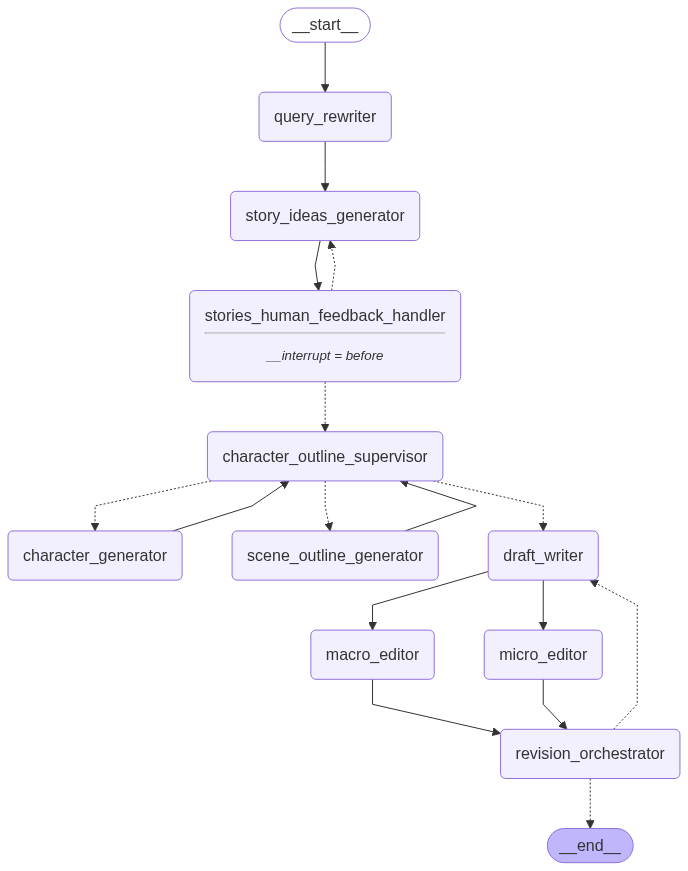

In [32]:
graph_builder = StateGraph(CreativeWritingAgentState)

graph_builder.add_node("query_rewriter", query_rewriter)
graph_builder.add_node("story_ideas_generator", story_ideas_generator)
graph_builder.add_node("stories_human_feedback_handler", stories_human_feedback_handler)
graph_builder.add_node("character_outline_supervisor", character_outline_supervisor)
graph_builder.add_node("character_generator", character_generator)
graph_builder.add_node("scene_outline_generator", scene_outline_generator)
graph_builder.add_node("draft_writer", draft_writer)
graph_builder.add_node("macro_editor", macro_editor)
graph_builder.add_node("micro_editor", micro_editor)
graph_builder.add_node("revision_orchestrator", revision_orchestrator)

graph_builder.add_edge(START, "query_rewriter")
graph_builder.add_edge("query_rewriter", "story_ideas_generator")
graph_builder.add_edge("story_ideas_generator", "stories_human_feedback_handler")
graph_builder.add_conditional_edges(
    "stories_human_feedback_handler",
    ideas_conditional_edge,
    {
        "character_outline_supervisor": "character_outline_supervisor",
        "story_ideas_generator": "story_ideas_generator"
    }
)

graph_builder.add_edge("character_generator", "character_outline_supervisor")
graph_builder.add_edge("scene_outline_generator", "character_outline_supervisor")
graph_builder.add_conditional_edges(
    "character_outline_supervisor",
    character_outline_conditional_edge,
    {
        "character_generator": "character_generator",
        "scene_outline_generator": "scene_outline_generator",
        "draft_writer": "draft_writer",
    }
)

graph_builder.add_edge("draft_writer", "macro_editor")
graph_builder.add_edge("draft_writer", "micro_editor")
graph_builder.add_edge("macro_editor", "revision_orchestrator")
graph_builder.add_edge("micro_editor", "revision_orchestrator")
graph_builder.add_conditional_edges(
    "revision_orchestrator",
    revision_orchestrator_conditional_edge,
    {
        "draft_writer": "draft_writer",
        END: END
    }
)

memory = MemorySaver()
graph= graph_builder.compile(interrupt_before=["stories_human_feedback_handler"], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [67]:
state = {
    "query": "A conversation at a family dinner table 2 parents 1 son elder and 1 daughter which moves from funny to a serious discussion about something interesting",
    "max_story_ideas": 5,
    "max_orchestrator_iterations": 5
}
config = {"configurable": {"thread_id": 31}, "recursion_limit": 30 }

for event in graph.stream(state, config=config):
    print(event)

{'query_rewriter': {'description': 'The user wants a scene set during a family dinner involving two parents, an elder son, and a daughter. The scene should transition from lighthearted and humorous to a serious and engaging discussion centered around an intriguing topic.', 'messages': [AIMessage(content='The user asked for a conversation at a family dinner table with 2 parents, 1 elder son and 1 daughter, which transitions from funny to a serious discussion about something interesting. I have expanded on this to clarify that the scene should start with humor and then shift to a serious and engaging discussion, also specifying that the topic of discussion should be intriguing to maintain reader interest. This provides a clearer direction for the writer.', additional_kwargs={}, response_metadata={}, id='068f7ce2-5f10-4c30-b445-242a39ed3078')]}}
Story 1:
Title: Dinner Truths
Synopsis: During a family dinner, a lighthearted game of 'truth or dare' takes a dark turn when long-hidden secrets

In [77]:
state = graph.get_state(config=config)
graph.update_state(config, {"human_feedback": "I like Blackout let's go with that"})

{'configurable': {'thread_id': '31',
  'checkpoint_ns': '',
  'checkpoint_id': '1f03c67d-ee11-62d8-800c-d16e7ff2e9f7'}}

In [78]:
state = graph.get_state(config=config)
state.values['human_feedback']

"I like Blackout let's go with that"

In [79]:
for event in graph.stream(None, config=config):
    print(event)

{'stories_human_feedback_handler': {'final_story_idea': StoryIdea(title='Blackout', synopsis='During a family dinner, a sudden blackout plunges the house into darkness. As tensions rise, old resentments and unspoken feelings surface, leading to a psychological game of cat and mouse. The family members must confront their inner demons and navigate the darkness, both literal and metaphorical, to survive the night.', genre=['Drama', 'Psychological', 'Thriller'], tone='Suspenseful and psychological', hook='A family dinner is interrupted by a sudden blackout, revealing hidden tensions and sparking a psychological game of cat and mouse.'), 'messages': [AIMessage(content="The user explicitly stated they like 'Blackout', which is story idea 5.  Therefore, I should select story idea 5", additional_kwargs={}, response_metadata={}, id='eb14df05-b506-448b-bfe1-5c0583f5265b')]}}
{'character_outline_supervisor': {'critic_character_feedback': ("Since no characters have been generated yet, it's imposs

In [80]:
state = graph.get_state(config=config)
state.next

()

In [81]:
state.values['characters']

[Characters(character_name='Robert', character_description="The patriarch, Robert, projects an image of control and success, but beneath the surface, he's plagued by insecurities and a fear of losing everything he's built. His control stems from a deep-seated need to keep his past embezzlement a secret.", character_backstory="Built his business empire from the ground up after a privileged but emotionally neglectful childhood. His father's constant criticism instilled a deep fear of failure. He secretly embezzled funds early in his career to save the business, a secret he guards fiercely.", character_goals='To maintain the illusion of control and success, both in his business and his family. To earn the respect he craved from his father. To ensure his past embezzlement remains hidden.', character_quirks='Obsessively checks the locks on doors and windows, even when the power is out. He has a specific tie that he wears to important meetings, believing it brings him luck. He avoids looking

In [82]:
state.values['draft']

'The chandelier, a skeletal hand dripping crystal, dominated the mahogany table. It was a monument to Robert\'s ambition, a frozen waterfall of light, even unlit. He sat at the head, a king surveying his domain, a kingdom that felt increasingly precarious. His smile, thin as a razor, reflected the polished silverware, a practiced mask over anxieties churning within him. Eleanor, across from him, possessed the stillness of a marble statue, her fingers intertwined so tightly the blood had fled, leaving only bone-white knuckles. Sarah, a storm cloud in ripped denim, stared fixedly at a point beyond the floral centerpiece, her silence a palpable rebellion. Only Billy, clutching his smooth, grey stone, seemed immune, lost in the tactile comfort of his talisman against a world he found unpredictable. The air, thick with the cloying sweetness of roasting lamb and the acrid tang of unspoken resentments, hung heavy, a suffocating blanket waiting for a spark.\n\nThen, the world vanished.\n\nNot 

In [83]:
Markdown(state.values['draft'])

The chandelier, a skeletal hand dripping crystal, dominated the mahogany table. It was a monument to Robert's ambition, a frozen waterfall of light, even unlit. He sat at the head, a king surveying his domain, a kingdom that felt increasingly precarious. His smile, thin as a razor, reflected the polished silverware, a practiced mask over anxieties churning within him. Eleanor, across from him, possessed the stillness of a marble statue, her fingers intertwined so tightly the blood had fled, leaving only bone-white knuckles. Sarah, a storm cloud in ripped denim, stared fixedly at a point beyond the floral centerpiece, her silence a palpable rebellion. Only Billy, clutching his smooth, grey stone, seemed immune, lost in the tactile comfort of his talisman against a world he found unpredictable. The air, thick with the cloying sweetness of roasting lamb and the acrid tang of unspoken resentments, hung heavy, a suffocating blanket waiting for a spark.

Then, the world vanished.

Not a gradual dimming, but a brutal amputation. Light bled out, leaving an oppressive, all-consuming black. Eleanor gasped, a fragile sound like a bird caught in a cage. Sarah's chair screeched back, a violent exclamation point in the sudden silence. Silverware chimed against the porcelain, a discordant melody of disruption. The chandelier, once a symbol of dominion, became a useless, looming threat.

"Damn it," Robert snapped, the word echoing in the void, betraying his carefully constructed control. His grip tightened on the table, his knuckles gleaming like polished bone. A pulse throbbed visibly in his temple.

"Robert," Eleanor breathed, her voice a fragile whisper. "It's likely just a breaker. I'll check." But the tremor in her voice, a subtle crack in her porcelain facade, hinted at a deeper unease.

Sarah shoved back from the table, the movement laced with defiance. "Maybe the darkness is finally getting smart."

Robert's head snapped up, his gaze hardening. "Sarah, enough. This isn't the time for your dramatics."

Billy flinched, his fingers digging into the smooth surface of his stone. The darkness wasn't empty. It writhed with shadows, whispering half-formed memories of a past he desperately tried to bury. He saw, in the inky black, the swirling chaos of that other blackout, the one they never mentioned, the one that clung to him like a shroud.

The scramble for light began, a frantic ballet of desperation. Robert, barking clipped orders, his phone's flashlight a meager, trembling beacon. Eleanor, a rustle of silk in the gloom, descended the basement stairs, each step precise, heavy with purpose. Sarah stalked off towards her room, a muttered curse her only farewell.

Feigning an attempt to reset the breaker, Eleanor found herself drawn to Robert's study. The door, always locked, stood slightly ajar, a silent invitation. A draft snaked from the room, carrying the familiar scent of his cologne mingled with something else… a faint, acrid sweetness, like burnt caramel. The air in the basement felt colder, the paintings seemed to press closer, their silent screams amplified by the darkness.

In the living room, moonlight, a sliver of cold silver, painted stark lines across the floor. Billy tugged at his mother's sleeve when she returned from the basement. "Mom," he whispered, his voice small and hesitant. "I keep dreaming…"

Eleanor knelt, her face obscured by shadow. "Tell me, darling."

"About the basement," he said, his voice trembling. "The paintings… they breathe. They watch me."

Eleanor's hand tightened on his. Her paintings, banished to the basement after Robert deemed them "unsuitable." She knew the paintings held a power, a dark reflection of the secrets she kept locked away. "Just dreams, Billy," she said, her voice strained, but her eyes betrayed her.

The argument erupted in the hallway, a jagged tear in the silence.

"Why do you have to suffocate everything, Dad?" Sarah's voice, sharp and accusatory, cut through the oppressive quiet. "Why can't you just let me be?" The words hung in the air, thick with years of unspoken frustration.

"Be? You want to drift through life, Sarah?" Robert roared, his voice tight with a fear he couldn't articulate. He scrubbed a hand across his face, the gesture revealing the exhaustion he usually kept hidden. "I'm trying to protect you."

"Protect me? Or control me? Afraid I'll actually create something, instead of just inheriting it?" Sarah spat back. She balled her fists, the knuckles white in the dim light filtering from Robert's phone. He saw, in that moment, a reflection of his own ambition, twisted and distorted by his fear.

Robert's breath hitched. He raised a hand, a dark shape looming in the darkness, then stopped, his fist clenched. He saw his father's disapproving face, the constant criticism that had fueled his relentless drive. He lowered his hand, the fight draining out of him, leaving him hollow. A bead of sweat traced a cold path down his temple.

Inside, moonlight illuminated the mahogany desk, revealing a letter tucked into a hidden compartment, a compartment she had known existed. Addressed to "Vivian, My Dearest." The words swam before her eyes, then snapped into focus, a cruel and precise revelation: "offshore accounts… irrevocable trust… plausible deniability."

The blood drained from Eleanor's face, leaving her skin cold and clammy. Vivian. The ghost in their marriage, a phantom limb that throbbed with unspoken pain. Now, the phantom had a name, a ledger, and a lawyer. She had suspected, but the confirmation was a physical blow, a punch to the gut that stole her breath. The air in the room seemed to thicken, pressing down on her, suffocating her.

She clutched the letter, her knuckles bone-white, and found Robert in the hallway, his face composed, a mask of indifference. She noticed the tremor in his left hand, a tell she had learned to decipher years ago, a subtle crack in his carefully constructed facade.

"Robert," she said, her voice a low, dangerous purr. "Who is Vivian, and what exactly are you planning to plausibly deny?"

He flinched, his composure momentarily fracturing. He reached for her, his fingers digging into her arm, his grip tighter than necessary. "Give me that letter, Eleanor."

Eleanor wrenched herself free, her eyes hardening to chips of ice. "I understand perfectly, Robert. You're a thief, a liar, and a coward. And I'm done playing the dutiful wife." The words were clipped, precise, each one a carefully aimed dart.

She turned, intending to expose him, but Robert blocked her path, his face contorted with desperation. "Please, Eleanor, don't do this. Think of the family."

"What family, Robert? The one built on stolen money and shattered dreams?" Eleanor asked, her voice laced with a bitter sadness.

The family gathered in the dining room, drawn by the escalating conflict, their faces pale and strained in the sliver of moonlight.

"What's going on?" Sarah asked, her voice trembling, but her eyes held a flicker of something akin to triumph. She saw her chance, finally, to break free from her father's suffocating grip.

Billy, clutching his stone, stared at his father, his eyes wide with a dawning understanding. "I saw you," he whispered, his voice barely audible. "That night. The other blackout. You were talking to a woman. By the gate." The memory, long suppressed, surfaced with startling clarity, triggered by the darkness and the rising tension.

Robert's face crumpled, his composure shattering completely. "It's not what you think," he choked out, his voice pleading, but utterly devoid of conviction. He ran a hand through his hair, the gesture revealing the raw panic beneath the surface.

His pleas were lost in the darkness, swallowed by years of deceit. The air crackled with unspoken truths, the weight of a family teetering on the precipice.

Then, a flicker. A hesitant spark. The lights in the basement flickered, then died again. A collective gasp filled the room. The emergency generator sputtered, coughed, and then roared to life, bathing the room in harsh, unforgiving light.

Robert, exposed, his face a mask of despair. Eleanor, standing tall, the letter clutched in her hand, her eyes filled with a cold, hard resolve. Sarah, staring at her father with a mixture of disgust and pity, her fingers twitching with a sudden, overwhelming urge to create. And Billy, his stone clutched tight, finally seeing the truth he had buried for so long, the truth that had haunted his dreams.

Eleanor turned and walked towards the door, the letter a weapon in her hand. Robert reached out to stop her, but Sarah stepped forward, blocking his path.

"Don't," she said, her voice surprisingly firm, laced with a newfound strength. "Just let her go." She met her father's gaze, her eyes filled with a mixture of defiance and a strange, unexpected compassion.

Eleanor paused, then continued towards the door, leaving Robert standing alone in the harsh light. His shoulders slumped, the picture of a defeated man.

Billy looked at his father, then at his mother, then back at his father. He opened his hand, revealing the smooth, grey stone. He walked over to Robert and pressed the stone into his hand. Robert closed his fingers around it, his gaze fixed on the floor, the weight of the stone a cold comfort.

Eleanor opened the front door and stepped out into the night. The cool air washed over her face, a welcome balm against the stifling atmosphere inside. She took a deep breath, a small, almost imperceptible smile playing on her lips. The darkness outside was vast, but for the first time in years, she felt a flicker of something akin to hope. She knew the road ahead would be treacherous, but she was finally free. As she walked away, she crumpled the letter in her hand, the evidence of Robert's betrayal becoming a symbol of her liberation.

Inside, Robert remained standing in the dining room, the weight of the stone heavy in his hand. He looked up at Billy, his eyes filled with a mixture of shame and regret. He opened his mouth to speak, but no words came out, only a dry, rasping sound. The silence stretched on, broken only by the soft ticking of the grandfather clock in the hall, a relentless reminder of the darkness that lingered within the house, and within him, perhaps forever.